In [1]:
from fastai.vision.all import *

In [2]:
path = untar_data(URLs.BIWI_HEAD_POSE)
path.ls()

(#50) [Path('/root/.fastai/data/biwi_head_pose/07'),Path('/root/.fastai/data/biwi_head_pose/22'),Path('/root/.fastai/data/biwi_head_pose/20'),Path('/root/.fastai/data/biwi_head_pose/11.obj'),Path('/root/.fastai/data/biwi_head_pose/16'),Path('/root/.fastai/data/biwi_head_pose/13.obj'),Path('/root/.fastai/data/biwi_head_pose/14.obj'),Path('/root/.fastai/data/biwi_head_pose/18'),Path('/root/.fastai/data/biwi_head_pose/10'),Path('/root/.fastai/data/biwi_head_pose/11')...]

In [3]:
(path/'01').ls()

(#1000) [Path('/root/.fastai/data/biwi_head_pose/01/frame_00121_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00288_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00445_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00339_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00113_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00126_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00100_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00021_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00473_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00389_pose.txt')...]

In [4]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('/root/.fastai/data/biwi_head_pose/07/frame_00667_pose.txt')

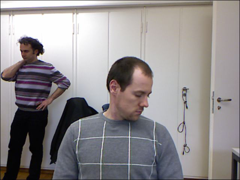

In [5]:
im = PILImage.create(img_files[0])
im.shape
im.to_thumb(240)

In [6]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer = 6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header = 3)
    c1 = ctr[0]*cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1]*cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])
get_ctr(img_files[0])

tensor([371.8633, 255.6989])

In [7]:
biwi = DataBlock(
    blocks =(ImageBlock, PointBlock),
    get_items = get_image_files,
    get_y = get_ctr,
    splitter = FuncSplitter(lambda o : o.parent.name =='13'),
    batch_tfms = [*aug_transforms(size = (240,320)),
                  Normalize.from_stats(*imagenet_stats)]
)

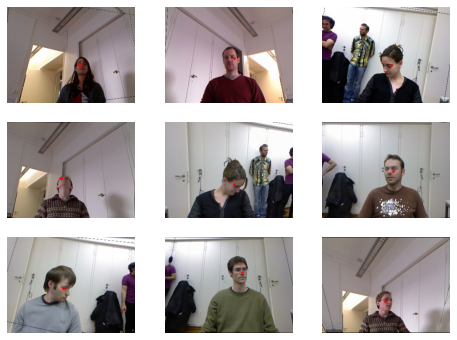

In [8]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n = 9, figsize = (8,6))

In [9]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

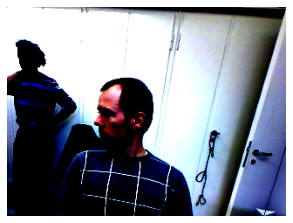

In [10]:
show_image(xb[0].float())

In [11]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:284: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f370

  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [12]:
dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(valley=0.03235936537384987)

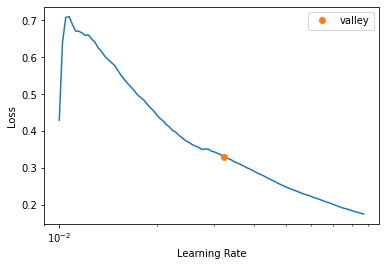

In [13]:
learn.lr_find(start_lr=1e-2, end_lr=1e-1, show_plot=True)

In [17]:
learn.fine_tune(3,1e-1)

epoch,train_loss,valid_loss,time
0,0.021210,0.001060,01:55


epoch,train_loss,valid_loss,time
0,0.007540,0.005185,01:57
1,0.003474,0.000274,02:07
2,0.001503,0.000066,01:59


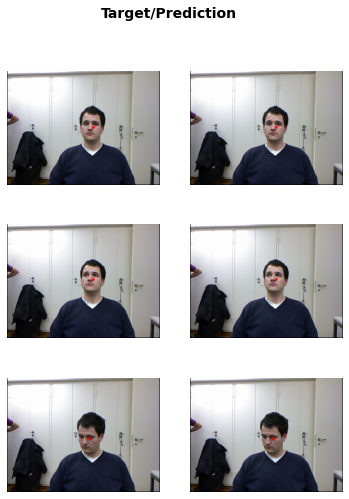

In [19]:
learn.show_results(ds_idx = 1, max_n = 3, figsize = (6,8))